# Pre-Processing and Training Data

## Remember

The purpose of this project is to build a predictive model for Economic index based on school demographics in NYC. This model will be used to provide guidance for NYC's education system plan and aim to decrease economic indexes by borough.








## The next step is to 

1. Load the data


2. Split the data 


3. Scale and ecode data if necessary


4. initiate the model 


5. Create the Pipeline


6. fit the pipeline


We are going to use PySpark Mlib

to train and prprocess our model.

We are also going to import the libraries we want to use first

In [244]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as e
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Initiate Spark

In [245]:
nyc_data_model = pd.read_csv('../data/nyc_data_modeling.csv')

In [246]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()

22/11/20 20:21:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [247]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=SparkByExamples.com>

In [248]:
#sc.stop()

In [249]:
print("Spark Version: {}".format(sc.version))

Spark Version: 3.3.1


In [250]:
print("Spark Version: {}".format(sc.pythonVer))

Spark Version: 3.9


In [251]:
print("Spark Version: {}".format(sc.master))

Spark Version: local[1]


# Load data

In [252]:
PATH = '../data/nyc_data_modeling.csv'

In [253]:
# Pandas

nyc_pandas = pd.read_csv(PATH).iloc[:,1:]

In [254]:
#Spark
nyc_spark = spark.read.csv(PATH, header=True, inferSchema=True)

PySpark makes no such inferences. By default, PySpark will treat the header as the first row and all columns as string variables. To prevent PySpark from making any false assumptions, the user must assign values to the header and inferSchema parameters.

In [255]:
nyc_pandas.head()

,Year,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,Borough,District Number,Economic Support,Pre School,Elementary School,Middle School,High School
0,2016-17,95,14,51,105,3,1,4,0,51,12,88.2,Manhattan,1,Need Support,45,133,0,0
1,2017-18,91,20,52,110,1,1,6,0,49,8,89.0,Manhattan,1,Need Support,45,145,0,0
2,2018-19,89,24,48,95,0,1,6,0,39,8,88.8,Manhattan,1,Need Support,33,141,0,0
3,2019-20,96,27,56,96,0,2,9,0,46,17,86.7,Manhattan,1,Need Support,43,147,0,0
4,2020-21,92,26,53,102,1,0,11,0,43,21,85.6,Manhattan,1,Need Support,46,147,0,0


Since PySpark implements lazy execution, it requires a trigger that derives the results of any operation. In this case, the show function acts as the trigger, letting the user view the loaded dataset.

In [256]:
nyc_pandas.describe()

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,District Number,Pre School,Elementary School,Middle School,High School
count,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000
mean,301.697241,95.272113,149.827898,239.106009,6.453594,6.534300,86.237321,2.524376,122.522303,80.493620,73.083172,27.062820,60.735304,220.988439,127.866834,176.365034
std,252.467601,217.404728,166.121062,223.101691,12.272638,14.409499,180.892501,8.999338,97.894632,106.569319,20.205806,26.072237,75.858914,260.187174,266.269458,467.812553
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,5.000000,41.000000,90.000000,1.000000,1.000000,6.000000,0.000000,67.000000,18.000000,63.300000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,245.000000,17.000000,102.000000,181.000000,2.000000,3.000000,15.000000,0.000000,99.000000,44.000000,79.200000,19.000000,46.000000,153.000000,0.000000,0.000000
75%,359.000000,81.000000,192.000000,313.000000,7.000000,7.000000,78.000000,1.000000,146.000000,100.000000,88.600000,29.000000,104.000000,389.000000,187.000000,248.000000
max,3635.000000,3671.000000,1493.000000,2056.000000,181.000000,355.000000,3104.000000,234.000000,925.000000,1168.000000,95.000000,84.000000,1328.000000,1688.000000,2265.000000,6040.000000


In [257]:
nyc_spark.describe().show()

22/11/20 20:21:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
 Schema: _c0, Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
Expected: _c0 but found: 
CSV file: file:///Users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/data/nyc_data_modeling.csv


+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+----------------------------+---------------------------+-------------------+-------------+------------------+----------------+-----------------+------------------+------------------+------------------+
|summary|              _c0|   Year|            # Male|           # Asian|           # Black|        # Hispanic|    # Multi-Racial| # Native American|          # White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|      Borough|   District Number|Economic Support|       Pre School| Elementary School|     Middle School|       High School|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+---

There is a random column in spark dataframe. Let's get rid of it.

In [258]:
nyc_spark = nyc_spark.drop('_c0')

We can also get rid of the categorical column economic support since we can directly predit the economic need index and deteremine which category it fits. 

In [259]:
nyc_spark = nyc_spark.drop('Economic Support')

In [260]:
print(nyc_spark.printSchema())

root
 |-- Year: string (nullable = true)
 |-- # Male: integer (nullable = true)
 |-- # Asian: integer (nullable = true)
 |-- # Black: integer (nullable = true)
 |-- # Hispanic: integer (nullable = true)
 |-- # Multi-Racial: integer (nullable = true)
 |-- # Native American: integer (nullable = true)
 |-- # White: integer (nullable = true)
 |-- # Missing Race/Ethnicity Data: integer (nullable = true)
 |-- # Students with Disabilities: integer (nullable = true)
 |-- # English Language Learners: integer (nullable = true)
 |-- Economic Need Index: double (nullable = true)
 |-- Borough: string (nullable = true)
 |-- District Number: integer (nullable = true)
 |-- Pre School: integer (nullable = true)
 |-- Elementary School: integer (nullable = true)
 |-- Middle School: integer (nullable = true)
 |-- High School: integer (nullable = true)

None


In [261]:
columns_to_drop = ['Economic Support']
nyc_spark = nyc_spark.drop(*columns_to_drop)
nyc_pandas = nyc_pandas.drop(['Economic Support'], axis=1)

### String Indexer -> OHEncode

In [262]:
indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
nyc_spark_index = indexer.fit(nyc_spark).transform(nyc_spark)

In [263]:
ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
ohe_encoder_index = ohe_encoder.fit(nyc_spark_index).transform(nyc_spark_index)

In [264]:
ohe_encoder_index.show()

+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+-----------+-------------+---------------------+----------+-------------+-------------------+-------------+
|   Year|# Male|# Asian|# Black|# Hispanic|# Multi-Racial|# Native American|# White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|  Borough|District Number|Pre School|Elementary School|Middle School|High School|Borough_label|District Number_label|Year_label|  Borough_ohe|District Number_ohe|     Year_ohe|
+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+----

### Scale the Data

In [265]:
vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       '# Native American', '# White', '# Missing Race/Ethnicity Data',
       '# Students with Disabilities', '# English Language Learners', 'Pre School',
       'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

vec_assemb = vec_assembler.transform(ohe_encoder_index)
vec_assemb

DataFrame[Year: string, # Male: int, # Asian: int, # Black: int, # Hispanic: int, # Multi-Racial: int, # Native American: int, # White: int, # Missing Race/Ethnicity Data: int, # Students with Disabilities: int, # English Language Learners: int, Economic Need Index: double, Borough: string, District Number: int, Pre School: int, Elementary School: int, Middle School: int, High School: int, Borough_label: double, District Number_label: double, Year_label: double, Borough_ohe: vector, District Number_ohe: vector, Year_ohe: vector, feature: vector]

In [270]:
from pyspark.ml.feature import StandardScaler
scaler =  StandardScaler().setInputCol('feature').setOutputCol("feature_scaled")
vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb)

## Split the data

In [271]:
(train_df, test_df) = vec_scaled_train.randomSplit([0.8, 0.2])

## Model 1. Linear Regression

The model I chose is linear Regression and I chose it since it is a classic regression model with linear algorithm. Simply all the calculation of the functions add up to the dependent variable.

I am going to use the following parameters and tune it.

1. elasticNetParam = 1.0
by setting it equal to 1.0, it means that it's lasso regression which is L1.

I chose L1 penalization over L2 because I have a lot of outliers in my data set. Since L1 takes the manhattan distance meaning it is penalizing the !absolute value! of the weights so it is more robust to outliers.

The down side of L1 would be the case when we have highly correlated features, the L1 norm would select only 1 of the features from the group of correlated features in an arbitrary nature so lasso regression also acts as a feature selector.

0.5 would be the mix of L1 and L2.

In general, Lasso regression (Linear Regression with L1 regularization) would produce a model that is highly interpretable, and only uses a subset of input features, thus reducing the complexity of the model.

2. MaxItr = 100,150,200,250
This has no reason. The higher the iteration, prone to overfit. 

3. regParam
This is unknown. We have to try multiple values


In [272]:
metric_list = []

In [273]:
linear_regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Tune the model now

In [274]:
# alpha = 0 - penalty L2
paramGrid = (ParamGridBuilder()
               .addGrid(linear_regressor.maxIter, [100,150,200,250])
               .addGrid(linear_regressor.elasticNetParam, [0.1,0.5,1.0])
               .addGrid(linear_regressor.regParam, [0.3,0.6,0.9])
               .build())

In [275]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="rmse")

regressorcv = CrossValidator(estimator = linear_regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)

linear_regression_cv = regressorcv.fit(train_df)

22/11/20 20:24:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/20 20:24:04 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Evaluate¶

In [276]:
lr_regressor_predictions = linear_regression_cv.transform(test_df)
print('RMSE:', evaluator.evaluate(lr_regressor_predictions))
metric_list.append(evaluator.evaluate(lr_regressor_predictions))

RMSE: 10.741259030201865


### Extra Notes about preprocessing

Sparks one hot encoder: have to convert String to index and then convert again to one hot encode.

sklearns one hot encoder: converts directly to index from String

so basically, the above solution is splitting the data after encoding and scaling and the bottom solution is I split the data first and encoded. According to the evaluation metrics, the score doesn't have a difference at all. Therefore, I prefer using the top method which contains less code. 

Steps:
Encode -> Scale(Normalize) -> Split -> Model -> Evaluate

### Encoding

In [ ]:
#from pyspark.ml.feature import OneHotEncoder
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.feature import StandardScaler

#indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
#label_df_train = indexer.fit(train_df).transform(train_df)
#label_df_test = indexer.fit(test_df).transform(test_df)

In [ ]:
#ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
#encoding_df_train = ohe_encoder.fit(label_df_train).transform(label_df_train)
#encoding_df_test = ohe_encoder.fit(label_df_test).transform(label_df_test)

### Scaling

In spark, when we scale, we have to perform vectorAssembler to perform Feature Vectorization meaning all the columns should be vectorized. 

In [ ]:
#vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       #'# Native American', '# White', '# Missing Race/Ethnicity Data',
       #'# Students with Disabilities', '# English Language Learners', 'Pre School',
       #'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

#vec_assemb_train = vec_assembler.transform(encoding_df_train)
#vec_assemb_test = vec_assembler.transform(encoding_df_test)

In [ ]:
#scaler = StandardScaler(inputCol='feature', outputCol='feature_scaled', withMean=True, withStd=True)
#vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb_train)
#vec_scaled_test = scaler.fit(vec_assemb).transform(vec_assemb_test)

### Create Model

In [ ]:
#from pyspark.ml.regression import LinearRegression

#regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

In [ ]:
#linear_model = regressor.fit(vec_scaled_train)

In [ ]:
#print("Coefficients: " + str(linear_model.coefficients))
#print("\nIntercept: " + str(linear_model.intercept))
#trainSummary = linear_model.summary
#print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

In [ ]:
#pred = linear_model.evaluate(vec_scaled_test)
#pred.predictions.toPandas().iloc[:,10:].head()

In [ ]:
#print('‘MAE for test set:’', pred.meanAbsoluteError)
#print('MSE for test set:', pred.meanSquaredError)
#print('RMSE for test set:', pred.rootMeanSquaredError)
#print('R2-Score for test set:', pred.r2)

### Model 2: Decision tree Regression

I chose Decision tree Regression because it is

In [277]:
regressor = DecisionTreeRegressor(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Binning feature values

Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication.

Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.

### Max depth

Increasing the depth leads to overfitting since it increases its complexity. 

## Tuning the model

In [278]:
paramGrid = (ParamGridBuilder()
               .addGrid(regressor.maxDepth, [2,5,10,2,30])
               .addGrid(regressor.maxBins, [10,20,40,80,100])
               .build())

### Evaluation

In [279]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="rmse")

regressorcv = CrossValidator(estimator = regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)


In [280]:
tree_regressor_model = regressorcv.fit(train_df)

22/11/20 20:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB
22/11/20 20:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1172.3 KiB
22/11/20 20:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1281.6 KiB
22/11/20 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1372.9 KiB
22/11/20 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1451.0 KiB
22/11/20 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1518.2 KiB
22/11/20 20:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1571.1 KiB
22/11/20 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1609.4 KiB
22/11/20 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1637.8 KiB
22/11/20 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1661.0 KiB
22/11/20 20:26:06 WARN DAGScheduler: Broadcasting large task binary with size 1678.6 KiB
22/11/20 20:26:06 WAR

22/11/20 20:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
22/11/20 20:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1162.5 KiB
22/11/20 20:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1276.7 KiB
22/11/20 20:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1378.0 KiB
22/11/20 20:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1464.8 KiB
22/11/20 20:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1535.9 KiB
22/11/20 20:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1592.8 KiB
22/11/20 20:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1632.4 KiB
22/11/20 20:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1664.0 KiB
22/11/20 20:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1687.4 KiB
22/11/20 20:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1705.4 KiB
22/11/20 20:26:38 WAR

22/11/20 20:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1035.8 KiB


22/11/20 20:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1156.9 KiB
22/11/20 20:27:17 WARN DAGScheduler: Broadcasting large task binary with size 1268.0 KiB
22/11/20 20:27:17 WARN DAGScheduler: Broadcasting large task binary with size 1362.0 KiB
22/11/20 20:27:18 WARN DAGScheduler: Broadcasting large task binary with size 1441.6 KiB
22/11/20 20:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1508.3 KiB
22/11/20 20:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1564.9 KiB
22/11/20 20:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB
22/11/20 20:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1646.3 KiB
22/11/20 20:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1674.2 KiB
22/11/20 20:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1696.8 KiB
22/11/20 20:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1715.7 KiB
22/11/20 20:27:21 WAR

22/11/20 20:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1033.3 KiB
22/11/20 20:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1170.4 KiB
22/11/20 20:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1288.7 KiB
22/11/20 20:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1378.0 KiB
22/11/20 20:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1447.7 KiB
22/11/20 20:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1510.3 KiB
22/11/20 20:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1561.4 KiB
22/11/20 20:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1603.8 KiB
22/11/20 20:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1642.8 KiB
22/11/20 20:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1673.0 KiB
22/11/20 20:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.7 KiB
22/11/20 20:27:59 WAR

22/11/20 20:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB


22/11/20 20:28:20 WARN DAGScheduler: Broadcasting large task binary with size 1147.0 KiB


22/11/20 20:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1254.1 KiB
22/11/20 20:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1352.1 KiB
22/11/20 20:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1439.1 KiB
22/11/20 20:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1509.5 KiB
22/11/20 20:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1566.3 KiB
22/11/20 20:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB
22/11/20 20:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1646.1 KiB
22/11/20 20:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1675.0 KiB
22/11/20 20:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1696.1 KiB
22/11/20 20:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1712.1 KiB
22/11/20 20:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1723.2 KiB
22/11/20 20:28:25 WAR

22/11/20 20:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB
22/11/20 20:28:33 WARN DAGScheduler: Broadcasting large task binary with size 1339.1 KiB
22/11/20 20:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1431.7 KiB
22/11/20 20:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1510.3 KiB
22/11/20 20:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1577.3 KiB
22/11/20 20:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1627.8 KiB
22/11/20 20:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1664.7 KiB
22/11/20 20:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1691.0 KiB
22/11/20 20:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1708.7 KiB
22/11/20 20:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1723.5 KiB
22/11/20 20:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1732.1 KiB
22/11/20 20:28:37 WAR

22/11/20 20:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
22/11/20 20:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
22/11/20 20:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1278.1 KiB
22/11/20 20:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1380.6 KiB
22/11/20 20:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1463.1 KiB
22/11/20 20:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1528.0 KiB
22/11/20 20:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1582.8 KiB
22/11/20 20:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/11/20 20:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1665.5 KiB
22/11/20 20:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1691.6 KiB
22/11/20 20:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1710.7 KiB
22/11/20 20:29:20 WAR

22/11/20 20:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
22/11/20 20:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1128.7 KiB
22/11/20 20:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1240.1 KiB
22/11/20 20:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/11/20 20:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1405.1 KiB
22/11/20 20:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1463.9 KiB
22/11/20 20:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1520.6 KiB
22/11/20 20:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1569.8 KiB
22/11/20 20:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1618.3 KiB
22/11/20 20:29:30 WARN DAGScheduler: Broadcasting large task binary with size 1654.0 KiB
22/11/20 20:29:30 WARN DAGScheduler: Broadcasting large task binary with size 1681.6 KiB
22/11/20 20:29:30 WAR

22/11/20 20:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1025.2 KiB


22/11/20 20:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1142.5 KiB


22/11/20 20:30:20 WARN DAGScheduler: Broadcasting large task binary with size 1254.5 KiB
22/11/20 20:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1354.4 KiB
22/11/20 20:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1441.1 KiB
22/11/20 20:30:22 WARN DAGScheduler: Broadcasting large task binary with size 1511.0 KiB
22/11/20 20:30:22 WARN DAGScheduler: Broadcasting large task binary with size 1567.6 KiB
22/11/20 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1614.0 KiB
22/11/20 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1650.9 KiB
22/11/20 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1677.3 KiB
22/11/20 20:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1697.9 KiB
22/11/20 20:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1714.7 KiB
22/11/20 20:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1726.1 KiB
22/11/20 20:30:24 WAR

In [281]:
regressor_predictions = tree_regressor_model.transform(test_df)
print('RMSE:', evaluator.evaluate(regressor_predictions))
metric_list.append(evaluator.evaluate(regressor_predictions))

RMSE: 8.176508084344723


## Model 3: Multilayer Perceptron

I am going to be using Keras for this. The reaason why i chose this model is to try out with the multi layer regression

This model is used for accuracy purposes sacrificing speed compared to the two above models. Since it performs better in large data than the normal linear regression and decision tree regressor, I will be using it. 

In [286]:
x = nyc_pandas.drop(['Economic Need Index'],axis=1)
y = nyc_pandas['Economic Need Index']

### Split the data

In [287]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state= 42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 40)

In [288]:
temp_columns = x_train.columns.tolist()

#index of desired column to move
index = x_train.columns.get_loc('Borough')
temp_columns = temp_columns[0:index]+temp_columns[index+1:]+temp_columns[index:index+1]

In [289]:
index = x_train.columns.get_loc('Year')

#Move to the last
temp_columns.pop(index)

'Year'

In [290]:
temp_columns.append('Year')

In [291]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'District Number',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year']

In [292]:
index1 = temp_columns.index('District Number')

temp_columns.pop(index1)

'District Number'

In [293]:
temp_columns.append('District Number')

In [294]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year',
 'District Number']

In [295]:
x_train = x_train[temp_columns]
x_val = x_val[temp_columns]
x_test = x_test[temp_columns]

In [296]:
x_train

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Pre School,Elementary School,Middle School,High School,Borough,Year,District Number
7891,230,14,93,174,0,20,7,0,307,98,1,0,66,241,Bronx,2020-21,75
1469,271,4,121,389,2,1,16,0,125,112,121,412,0,0,Bronx,2020-21,7
4089,75,8,91,23,1,0,10,0,41,27,0,0,133,0,Brooklyn,2018-19,17
3413,176,15,285,31,1,5,12,14,50,4,0,0,0,363,Brooklyn,2018-19,13
3235,262,4,133,319,2,6,6,1,150,60,0,0,0,471,Bronx,2018-19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7839,367,117,81,210,5,6,64,0,483,207,93,235,97,58,Queens,2018-19,75
3603,330,26,143,485,1,6,44,14,132,32,0,0,0,719,Brooklyn,2020-21,14
5959,584,771,50,124,12,1,202,0,151,89,0,0,1160,0,Queens,2017-18,26
5426,625,681,7,486,1,8,36,0,183,357,203,1016,0,0,Queens,2017-18,24


### Encode

### x_train

In [299]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(x_train[['Year','Borough','District Number']])

print(encoder.categories_)
encoded_x_train = encoder.transform(x_train[['Year','Borough','District Number']]).toarray()

print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train = pd.DataFrame(encoded_x_train, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train.head()

print(encoded_x_train.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### x_val

In [300]:
encoder = OneHotEncoder()
encoder.fit(x_val[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_val = encoder.transform(x_val[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val = pd.DataFrame(encoded_x_val, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val.head()
print(encoded_x_val.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

In [301]:
encoder = OneHotEncoder()
encoder.fit(x_test[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_test = encoder.transform(x_test[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test = pd.DataFrame(encoded_x_test, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test.head()
print(encoded_x_test.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### Scale

In [306]:
from sklearn.preprocessing import StandardScaler
column_insert = x_train.loc[:,:'High School'].columns
sc = StandardScaler()
x_train_scaled = pd.DataFrame(sc.fit_transform(x_train.loc[:,:'High School']),columns = column_insert)
x_test_scaled = pd.DataFrame(sc.fit_transform(x_test.loc[:,:'High School']),columns = column_insert)
x_val_scaled = pd.DataFrame(sc.fit_transform(x_val.loc[:,:'High School']),columns=column_insert)

In [307]:
x_train_scaled.shape

(7335, 14)

In [308]:
x_test_scaled.shape

(1834, 14)

In [309]:
x_val_scaled.shape

(1834, 14)

In [310]:
print(x_train_scaled.index)
print(encoded_x_train.index)

RangeIndex(start=0, stop=7335, step=1)
RangeIndex(start=0, stop=7335, step=1)


In [311]:
print(x_val_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [312]:
print(x_test_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [313]:
final_df_x_train = pd.concat([encoded_x_train,x_train_scaled],axis=1)
final_df_x_val= pd.concat([encoded_x_val,x_val_scaled],axis=1)
final_df_x_test = pd.concat([encoded_x_test,x_test_scaled],axis=1)

### Initialize model

In [315]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = final_df_x_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'sgd', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(final_df_x_train,y_train, batch_size = 64, epochs= 50, validation_data=(final_df_x_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 3ms/step - loss: 70.5582 - root_mean_squared_error: 73.4195 - val_loss: 66.1037 - val_root_mean_squared_error: 69.0180
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 46.7916 - root_mean_squared_error: 52.4369 - val_loss: 19.6111 - val_root_mean_squared_error: 24.6389
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 10.5035 - root_mean_squared_error: 14.3852 - val_loss: 7.8137 - val_root_mean_squared_error: 10.6257
Epoch 4/50
115/115 [==============================] - 0s 2ms/step - loss: 7.5246 - root_mean_squared_error: 10.4629 - val_loss: 7.1629 - val_root_mean_squared_error: 9.8931
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 7.0527 - root_mean_squared_error: 9.8614 - val_loss: 6.8209 - val_root_mean_squared_error: 9.5238
Epoch 6/50
115/115 [==============================] - 0s 2ms/step - loss: 6.7976 - root_mean_squared_error: 9.5107 - val_loss: 6

In [316]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

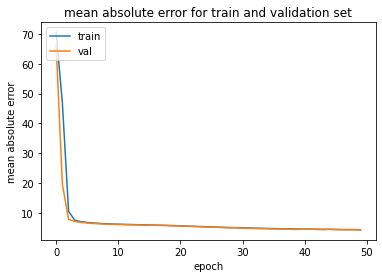

In [317]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I can see that my model is over fitting. 

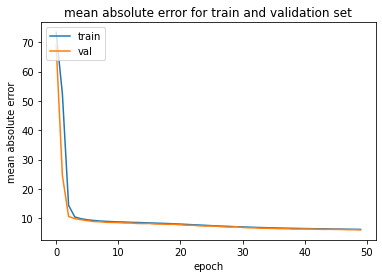

In [318]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I chose the activatioon function ReLU in the hidden layer. It is a commonly used activation function where if the input x is negative, then a value 0 is returned. 

We can penalize high errors with RMSE so we use rmse.

By analysis, we find that compared with ADAM, SGD is more locally unstable and is more likely to converge to the minima at the flat or asymmetric basins/valleys which often have better generalization performance over other type minima. So our results can explain the better generalization performance of SGD over ADAM. SO i didnt use adams

Source: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [319]:
# getting the metrics

def metrics_for_mlp():
    y_pred = model.predict(final_df_x_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    return rmse

In [320]:
metrics_for_mlp()

58/58 [==============================] - 0s 2ms/step


6.7597635096393764

In [321]:
metric_list.append(round(6.78,2))

### Cat Boost

In [328]:
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

catboost_model = CatBoostRegressor()

In [331]:
def cb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.01,0.2)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    depth = trial.suggest_int('depth', 1,10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3,15)
    
    cb = CatBoostRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators,
                            depth = depth, 
                            l2_leaf_reg= l2_leaf_reg, 
                            loss_function = 'RMSE')
    
    cb.fit(final_df_x_train, y_train)
    
    y_pred = cb.predict(final_df_x_val)
    
    return mean_squared_error(y_val, y_pred, squared=False)

study = optuna.create_study(direction = 'minimize')
study.optimize(cb_objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
    

[I 2022-11-21 16:31:00,279] A new study created in memory with name: no-name-6479640a-03a9-4c8a-8670-10b2f68e69ee


0:	learn: 18.6476280	total: 52ms	remaining: 16.7s
1:	learn: 17.2624228	total: 54.7ms	remaining: 8.75s
2:	learn: 16.0407850	total: 57.3ms	remaining: 6.09s
3:	learn: 14.9841983	total: 59.7ms	remaining: 4.75s
4:	learn: 14.0100496	total: 63.2ms	remaining: 4s
5:	learn: 13.2201368	total: 67.5ms	remaining: 3.56s
6:	learn: 12.4652739	total: 70.1ms	remaining: 3.16s
7:	learn: 11.7771745	total: 73.4ms	remaining: 2.88s
8:	learn: 11.1934208	total: 76.1ms	remaining: 2.65s
9:	learn: 10.7085790	total: 79.6ms	remaining: 2.48s
10:	learn: 10.2414899	total: 82.6ms	remaining: 2.33s
11:	learn: 9.8426360	total: 86.1ms	remaining: 2.22s
12:	learn: 9.4683320	total: 88.6ms	remaining: 2.11s
13:	learn: 9.1720351	total: 90.9ms	remaining: 2s
14:	learn: 8.8833032	total: 93.8ms	remaining: 1.92s
15:	learn: 8.6359770	total: 96.8ms	remaining: 1.85s
16:	learn: 8.4030592	total: 99.3ms	remaining: 1.78s
17:	learn: 8.2014620	total: 102ms	remaining: 1.72s
18:	learn: 8.0462240	total: 105ms	remaining: 1.67s
19:	learn: 7.8642008	

[I 2022-11-21 16:31:01,862] Trial 0 finished with value: 3.9755806216390477 and parameters: {'learning_rate': 0.12734176669788547, 'n_estimators': 322, 'depth': 6, 'l2_leaf_reg': 15}. Best is trial 0 with value: 3.9755806216390477.


280:	learn: 3.7109269	total: 1.06s	remaining: 154ms
281:	learn: 3.7091982	total: 1.06s	remaining: 151ms
282:	learn: 3.7029121	total: 1.06s	remaining: 147ms
283:	learn: 3.6963200	total: 1.07s	remaining: 143ms
284:	learn: 3.6924178	total: 1.07s	remaining: 139ms
285:	learn: 3.6875335	total: 1.07s	remaining: 135ms
286:	learn: 3.6827541	total: 1.08s	remaining: 132ms
287:	learn: 3.6785119	total: 1.08s	remaining: 128ms
288:	learn: 3.6732451	total: 1.08s	remaining: 124ms
289:	learn: 3.6687149	total: 1.09s	remaining: 120ms
290:	learn: 3.6625496	total: 1.09s	remaining: 117ms
291:	learn: 3.6568507	total: 1.1s	remaining: 113ms
292:	learn: 3.6548832	total: 1.1s	remaining: 109ms
293:	learn: 3.6514652	total: 1.1s	remaining: 105ms
294:	learn: 3.6467896	total: 1.11s	remaining: 101ms
295:	learn: 3.6439589	total: 1.11s	remaining: 97.6ms
296:	learn: 3.6409957	total: 1.11s	remaining: 93.7ms
297:	learn: 3.6363377	total: 1.11s	remaining: 89.9ms
298:	learn: 3.6337727	total: 1.12s	remaining: 86.1ms
299:	learn:

[I 2022-11-21 16:31:03,466] Trial 1 finished with value: 3.554294584326993 and parameters: {'learning_rate': 0.1596297433219325, 'n_estimators': 402, 'depth': 6, 'l2_leaf_reg': 8}. Best is trial 1 with value: 3.554294584326993.


360:	learn: 2.9195321	total: 1.21s	remaining: 138ms
361:	learn: 2.9151069	total: 1.22s	remaining: 135ms
362:	learn: 2.9113720	total: 1.22s	remaining: 131ms
363:	learn: 2.9084691	total: 1.23s	remaining: 128ms
364:	learn: 2.9048144	total: 1.23s	remaining: 125ms
365:	learn: 2.9014194	total: 1.23s	remaining: 121ms
366:	learn: 2.8966674	total: 1.24s	remaining: 118ms
367:	learn: 2.8918710	total: 1.24s	remaining: 115ms
368:	learn: 2.8908315	total: 1.24s	remaining: 111ms
369:	learn: 2.8874432	total: 1.25s	remaining: 108ms
370:	learn: 2.8855077	total: 1.25s	remaining: 104ms
371:	learn: 2.8823300	total: 1.25s	remaining: 101ms
372:	learn: 2.8797347	total: 1.25s	remaining: 97.6ms
373:	learn: 2.8755883	total: 1.26s	remaining: 94.3ms
374:	learn: 2.8731556	total: 1.26s	remaining: 90.9ms
375:	learn: 2.8697588	total: 1.27s	remaining: 87.5ms
376:	learn: 2.8648901	total: 1.27s	remaining: 84.1ms
377:	learn: 2.8619346	total: 1.27s	remaining: 80.7ms
378:	learn: 2.8594053	total: 1.27s	remaining: 77.4ms
379:	

[I 2022-11-21 16:31:03,845] Trial 2 finished with value: 5.656112927209337 and parameters: {'learning_rate': 0.13353443698563747, 'n_estimators': 165, 'depth': 3, 'l2_leaf_reg': 8}. Best is trial 1 with value: 3.554294584326993.


110:	learn: 6.0062494	total: 200ms	remaining: 97.3ms
111:	learn: 6.0014599	total: 204ms	remaining: 96.8ms
112:	learn: 5.9905008	total: 208ms	remaining: 95.7ms
113:	learn: 5.9779701	total: 213ms	remaining: 95.1ms
114:	learn: 5.9680920	total: 214ms	remaining: 93.1ms
115:	learn: 5.9533298	total: 216ms	remaining: 91.4ms
116:	learn: 5.9404790	total: 220ms	remaining: 90.2ms
117:	learn: 5.9233575	total: 222ms	remaining: 88.6ms
118:	learn: 5.9118454	total: 224ms	remaining: 86.7ms
119:	learn: 5.8991543	total: 227ms	remaining: 85ms
120:	learn: 5.8871424	total: 229ms	remaining: 83.2ms
121:	learn: 5.8787181	total: 231ms	remaining: 81.3ms
122:	learn: 5.8694005	total: 233ms	remaining: 79.4ms
123:	learn: 5.8615437	total: 235ms	remaining: 77.7ms
124:	learn: 5.8483295	total: 237ms	remaining: 75.7ms
125:	learn: 5.8379315	total: 238ms	remaining: 73.7ms
126:	learn: 5.8226633	total: 240ms	remaining: 71.9ms
127:	learn: 5.8086819	total: 243ms	remaining: 70.1ms
128:	learn: 5.8049359	total: 245ms	remaining: 68

[I 2022-11-21 16:31:08,132] Trial 3 finished with value: 3.952744114147411 and parameters: {'learning_rate': 0.04400425965615944, 'n_estimators': 489, 'depth': 8, 'l2_leaf_reg': 10}. Best is trial 1 with value: 3.554294584326993.


0:	learn: 19.1919050	total: 2.64ms	remaining: 962ms
1:	learn: 18.3374334	total: 7.6ms	remaining: 1.38s
2:	learn: 17.6787162	total: 8.82ms	remaining: 1.06s
3:	learn: 17.0337523	total: 10.5ms	remaining: 944ms
4:	learn: 16.5167475	total: 11.9ms	remaining: 858ms
5:	learn: 16.1128204	total: 13.7ms	remaining: 822ms
6:	learn: 15.7476622	total: 14.9ms	remaining: 762ms
7:	learn: 15.4490101	total: 16.2ms	remaining: 725ms
8:	learn: 15.1806514	total: 18.2ms	remaining: 722ms
9:	learn: 14.9195238	total: 20.1ms	remaining: 714ms
10:	learn: 14.6898782	total: 22ms	remaining: 707ms
11:	learn: 14.4611864	total: 23.4ms	remaining: 689ms
12:	learn: 14.2439088	total: 24.8ms	remaining: 672ms
13:	learn: 14.0587175	total: 26.2ms	remaining: 658ms
14:	learn: 13.8801085	total: 27.6ms	remaining: 645ms
15:	learn: 13.7083027	total: 28.9ms	remaining: 630ms
16:	learn: 13.5432151	total: 30.2ms	remaining: 617ms
17:	learn: 13.3829529	total: 33ms	remaining: 635ms
18:	learn: 13.2400348	total: 34.5ms	remaining: 628ms
19:	lear

[I 2022-11-21 16:31:09,171] Trial 4 finished with value: 7.422454433940195 and parameters: {'learning_rate': 0.12656667924003878, 'n_estimators': 365, 'depth': 1, 'l2_leaf_reg': 4}. Best is trial 1 with value: 3.554294584326993.


318:	learn: 7.3344099	total: 653ms	remaining: 94.2ms
319:	learn: 7.3314355	total: 654ms	remaining: 92ms
320:	learn: 7.3301882	total: 657ms	remaining: 90.1ms
321:	learn: 7.3280417	total: 660ms	remaining: 88.1ms
322:	learn: 7.3252807	total: 661ms	remaining: 85.9ms
323:	learn: 7.3225537	total: 664ms	remaining: 84ms
324:	learn: 7.3196081	total: 668ms	remaining: 82.2ms
325:	learn: 7.3167436	total: 670ms	remaining: 80.1ms
326:	learn: 7.3137732	total: 672ms	remaining: 78ms
327:	learn: 7.3106402	total: 674ms	remaining: 76ms
328:	learn: 7.3076471	total: 676ms	remaining: 74ms
329:	learn: 7.3047179	total: 680ms	remaining: 72.1ms
330:	learn: 7.3019433	total: 685ms	remaining: 70.4ms
331:	learn: 7.2990151	total: 687ms	remaining: 68.3ms
332:	learn: 7.2962142	total: 688ms	remaining: 66.2ms
333:	learn: 7.2932109	total: 690ms	remaining: 64ms
334:	learn: 7.2908758	total: 691ms	remaining: 61.9ms
335:	learn: 7.2876862	total: 693ms	remaining: 59.8ms
336:	learn: 7.2849535	total: 694ms	remaining: 57.6ms
337:	

[I 2022-11-21 16:31:09,642] Trial 5 finished with value: 5.965822538761047 and parameters: {'learning_rate': 0.09446043451551467, 'n_estimators': 110, 'depth': 4, 'l2_leaf_reg': 4}. Best is trial 1 with value: 3.554294584326993.


0:	learn: 19.1427079	total: 8.27ms	remaining: 2.39s
1:	learn: 18.1158418	total: 13.4ms	remaining: 1.93s
2:	learn: 17.2204784	total: 18.4ms	remaining: 1.76s
3:	learn: 16.3805406	total: 24.3ms	remaining: 1.73s
4:	learn: 15.5938627	total: 31.2ms	remaining: 1.78s
5:	learn: 14.8826633	total: 35.7ms	remaining: 1.69s
6:	learn: 14.2618340	total: 44.6ms	remaining: 1.8s
7:	learn: 13.6405895	total: 50.6ms	remaining: 1.78s
8:	learn: 13.0776870	total: 55.8ms	remaining: 1.74s
9:	learn: 12.5526264	total: 61.2ms	remaining: 1.71s
10:	learn: 12.0758741	total: 67ms	remaining: 1.7s
11:	learn: 11.6479175	total: 72.9ms	remaining: 1.69s
12:	learn: 11.2268145	total: 79.2ms	remaining: 1.69s
13:	learn: 10.8507438	total: 83.8ms	remaining: 1.65s
14:	learn: 10.4840635	total: 89.4ms	remaining: 1.64s
15:	learn: 10.1805596	total: 94.1ms	remaining: 1.61s
16:	learn: 9.8783343	total: 98.9ms	remaining: 1.59s
17:	learn: 9.6503389	total: 104ms	remaining: 1.57s
18:	learn: 9.3889107	total: 109ms	remaining: 1.55s
19:	learn: 9

[I 2022-11-21 16:31:11,310] Trial 6 finished with value: 4.134140048979093 and parameters: {'learning_rate': 0.085721027030013, 'n_estimators': 290, 'depth': 7, 'l2_leaf_reg': 13}. Best is trial 1 with value: 3.554294584326993.


0:	learn: 18.7044862	total: 9.34ms	remaining: 1.08s
1:	learn: 17.3253157	total: 17.2ms	remaining: 990ms
2:	learn: 16.1151937	total: 27.4ms	remaining: 1.04s
3:	learn: 15.0716461	total: 31.4ms	remaining: 886ms
4:	learn: 14.1337775	total: 40.2ms	remaining: 900ms
5:	learn: 13.3162426	total: 45.1ms	remaining: 834ms
6:	learn: 12.5984360	total: 50.8ms	remaining: 799ms
7:	learn: 11.9264145	total: 56.5ms	remaining: 770ms
8:	learn: 11.4043156	total: 61.6ms	remaining: 739ms
9:	learn: 10.8569571	total: 70.2ms	remaining: 751ms
10:	learn: 10.3698432	total: 74.5ms	remaining: 718ms
11:	learn: 9.9360885	total: 79ms	remaining: 691ms
12:	learn: 9.5804285	total: 86.7ms	remaining: 694ms
13:	learn: 9.2576891	total: 92.2ms	remaining: 678ms
14:	learn: 8.9443463	total: 98.5ms	remaining: 670ms
15:	learn: 8.6641636	total: 104ms	remaining: 653ms
16:	learn: 8.4388735	total: 109ms	remaining: 640ms
17:	learn: 8.2222816	total: 118ms	remaining: 651ms
18:	learn: 8.0126986	total: 123ms	remaining: 636ms
19:	learn: 7.8428

[I 2022-11-21 16:31:12,258] Trial 7 finished with value: 4.865314749341168 and parameters: {'learning_rate': 0.11986432860232091, 'n_estimators': 117, 'depth': 7, 'l2_leaf_reg': 13}. Best is trial 1 with value: 3.554294584326993.


91:	learn: 4.9094065	total: 702ms	remaining: 191ms
92:	learn: 4.8948325	total: 708ms	remaining: 183ms
93:	learn: 4.8746957	total: 714ms	remaining: 175ms
94:	learn: 4.8680739	total: 719ms	remaining: 167ms
95:	learn: 4.8517626	total: 726ms	remaining: 159ms
96:	learn: 4.8428341	total: 735ms	remaining: 152ms
97:	learn: 4.8151712	total: 742ms	remaining: 144ms
98:	learn: 4.7947559	total: 748ms	remaining: 136ms
99:	learn: 4.7923859	total: 752ms	remaining: 128ms
100:	learn: 4.7802464	total: 757ms	remaining: 120ms
101:	learn: 4.7628021	total: 762ms	remaining: 112ms
102:	learn: 4.7432517	total: 768ms	remaining: 104ms
103:	learn: 4.7316014	total: 773ms	remaining: 96.6ms
104:	learn: 4.7268047	total: 778ms	remaining: 89ms
105:	learn: 4.7093675	total: 784ms	remaining: 81.4ms
106:	learn: 4.6982990	total: 790ms	remaining: 73.8ms
107:	learn: 4.6878193	total: 795ms	remaining: 66.2ms
108:	learn: 4.6764432	total: 799ms	remaining: 58.6ms
109:	learn: 4.6635525	total: 803ms	remaining: 51.1ms
110:	learn: 4.65

[I 2022-11-21 16:31:13,199] Trial 8 finished with value: 4.835875927311776 and parameters: {'learning_rate': 0.09246207176112756, 'n_estimators': 228, 'depth': 5, 'l2_leaf_reg': 12}. Best is trial 1 with value: 3.554294584326993.


199:	learn: 4.7825579	total: 686ms	remaining: 96ms
200:	learn: 4.7770157	total: 689ms	remaining: 92.5ms
201:	learn: 4.7682225	total: 691ms	remaining: 89ms
202:	learn: 4.7576052	total: 694ms	remaining: 85.4ms
203:	learn: 4.7494731	total: 696ms	remaining: 81.9ms
204:	learn: 4.7470942	total: 698ms	remaining: 78.3ms
205:	learn: 4.7457932	total: 701ms	remaining: 74.9ms
206:	learn: 4.7382415	total: 704ms	remaining: 71.4ms
207:	learn: 4.7284371	total: 706ms	remaining: 67.8ms
208:	learn: 4.7217664	total: 707ms	remaining: 64.3ms
209:	learn: 4.7149607	total: 709ms	remaining: 60.8ms
210:	learn: 4.7052055	total: 712ms	remaining: 57.3ms
211:	learn: 4.7039105	total: 714ms	remaining: 53.9ms
212:	learn: 4.6979249	total: 716ms	remaining: 50.4ms
213:	learn: 4.6922489	total: 719ms	remaining: 47ms
214:	learn: 4.6873339	total: 721ms	remaining: 43.6ms
215:	learn: 4.6801686	total: 723ms	remaining: 40.2ms
216:	learn: 4.6700523	total: 726ms	remaining: 36.8ms
217:	learn: 4.6653522	total: 728ms	remaining: 33.4ms

[I 2022-11-21 16:31:21,425] Trial 9 finished with value: 4.7085077413694565 and parameters: {'learning_rate': 0.019408796958056317, 'n_estimators': 365, 'depth': 10, 'l2_leaf_reg': 5}. Best is trial 1 with value: 3.554294584326993.


360:	learn: 4.3384810	total: 7.93s	remaining: 87.9ms
361:	learn: 4.3348650	total: 7.95s	remaining: 65.9ms
362:	learn: 4.3314367	total: 7.96s	remaining: 43.9ms
363:	learn: 4.3267099	total: 7.98s	remaining: 21.9ms
364:	learn: 4.3212453	total: 8s	remaining: 0us
Best Score: 3.554294584326993
Best trial: {'learning_rate': 0.1596297433219325, 'n_estimators': 402, 'depth': 6, 'l2_leaf_reg': 8}


In [338]:
cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

y_pred = cat.predict(final_df_x_test)
y_val_pred = cat.predict(final_df_x_val)


rmse_train = (np.sqrt(mean_squared_error(y_train,y_train)))
rmse_val = (np.sqrt(mean_squared_error(y_val,y_val_pred)))
rmse = (np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test,y_pred)

print("Testing Performance")
print('RMSE train: {:.2f}'.format(rmse_train))
print('RMSE val : {:.2f}'.format(rmse_val))
print('RMSE test: {:.2f}'.format(rmse))
print('r2:{:.2f}'.format(r2))

0:	learn: 18.1412559	total: 4.7ms	remaining: 1.89s
1:	learn: 16.3990200	total: 10.4ms	remaining: 2.07s
2:	learn: 15.0165423	total: 16.4ms	remaining: 2.18s
3:	learn: 13.8581408	total: 21.2ms	remaining: 2.11s
4:	learn: 12.8106009	total: 25.3ms	remaining: 2.01s
5:	learn: 11.9820239	total: 28.9ms	remaining: 1.91s
6:	learn: 11.1942151	total: 34.2ms	remaining: 1.93s
7:	learn: 10.5166134	total: 37.6ms	remaining: 1.85s
8:	learn: 9.9210317	total: 41.7ms	remaining: 1.82s
9:	learn: 9.5427220	total: 44ms	remaining: 1.73s
10:	learn: 9.1340319	total: 46ms	remaining: 1.64s
11:	learn: 8.8089711	total: 48.7ms	remaining: 1.58s
12:	learn: 8.4508629	total: 52.1ms	remaining: 1.56s
13:	learn: 8.1812703	total: 54.6ms	remaining: 1.51s
14:	learn: 7.9474008	total: 57ms	remaining: 1.47s
15:	learn: 7.7161086	total: 59.5ms	remaining: 1.44s
16:	learn: 7.5299823	total: 61.9ms	remaining: 1.4s
17:	learn: 7.3872007	total: 64.8ms	remaining: 1.38s
18:	learn: 7.2591370	total: 67.3ms	remaining: 1.36s
19:	learn: 7.1202061	t

In [343]:
metric_list.append(rmse)

This is incredible. The RMSE score is so low. And it shows training set RMSE is higher than RMSE test. 

In [346]:
result_df = pd.DataFrame(metric_list, index = ['Lasso Regression','Decision Tree Regressor','Multilayer Perceptron','Catboost'], columns = ['Root Mean Square Error'])
result_df

,Root Mean Square Error
Lasso Regression,10.741259
Decision Tree Regressor,8.176508
Multilayer Perceptron,6.780000
Catboost,4.443611


## SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Resource: https://github.com/slundberg/shap

0:	learn: 18.1412559	total: 6.76ms	remaining: 2.71s
1:	learn: 16.3990200	total: 9.5ms	remaining: 1.9s
2:	learn: 15.0165423	total: 13.6ms	remaining: 1.81s
3:	learn: 13.8581408	total: 18.6ms	remaining: 1.85s
4:	learn: 12.8106009	total: 22.1ms	remaining: 1.75s
5:	learn: 11.9820239	total: 26.5ms	remaining: 1.75s
6:	learn: 11.1942151	total: 33.9ms	remaining: 1.91s
7:	learn: 10.5166134	total: 42.6ms	remaining: 2.1s
8:	learn: 9.9210317	total: 48.9ms	remaining: 2.13s
9:	learn: 9.5427220	total: 52.6ms	remaining: 2.06s
10:	learn: 9.1340319	total: 55ms	remaining: 1.96s
11:	learn: 8.8089711	total: 57.8ms	remaining: 1.88s
12:	learn: 8.4508629	total: 60.5ms	remaining: 1.81s
13:	learn: 8.1812703	total: 63.2ms	remaining: 1.75s
14:	learn: 7.9474008	total: 66.4ms	remaining: 1.71s
15:	learn: 7.7161086	total: 70.6ms	remaining: 1.7s
16:	learn: 7.5299823	total: 74.8ms	remaining: 1.69s
17:	learn: 7.3872007	total: 78.4ms	remaining: 1.67s
18:	learn: 7.2591370	total: 82.4ms	remaining: 1.66s
19:	learn: 7.1202061

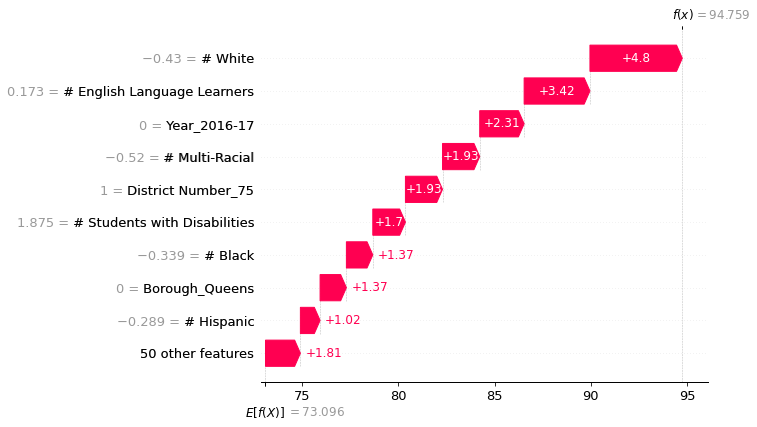

In [351]:
import shap

cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

explainer = shap.Explainer(cat)
shap_values = explainer(final_df_x_train)

shap.plots.waterfall(shap_values[0])

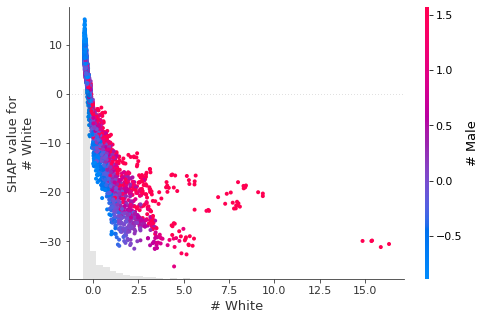

In [359]:
shap.plots.scatter(shap_values[:,'# White'], color=shap_values)

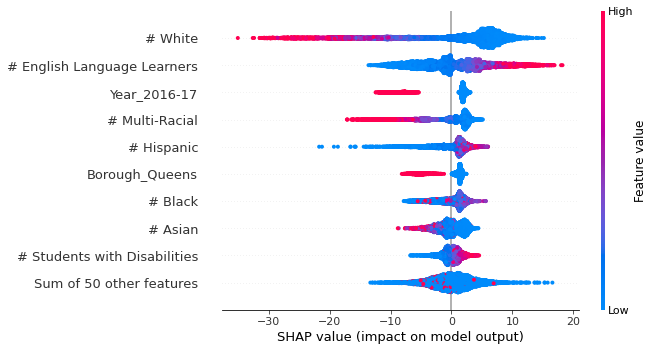

In [360]:
shap.plots.beeswarm(shap_values)

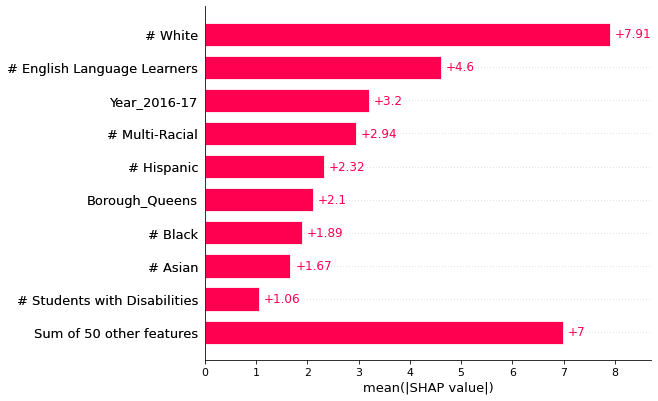

In [361]:
shap.plots.bar(shap_values)

### Choosing the right model.

CatBoost is the best model with RMSE score of 4.443611.

• Validation set RMSE score: 3.55
• Test set RMSE score: 4.44

With this highly accuracte model, we can predict the economic index by the corresponding values borough,grade,race in New York City. The mae would be 4.86 which is highly accurate. 